In [2]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [27]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
train_dataset = datasets.MNIST(root="data/mnist/",
                               train=True,
                               download=True,
                               transform=transform)
train_dataset,val_dataset = train_test_split(train_dataset,test_size=0.1,random_state=0)
train_loader = DataLoader(dataset=train_dataset,shuffle=True,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset,shuffle=False,batch_size=batch_size)
test_dataset = datasets.MNIST(root="data/mnist/",
                               train=False,
                               download=True,
                               transform=transform)
test_loader = DataLoader(dataset=test_dataset,shuffle=False,batch_size=batch_size)
print("train:",len(train_dataset),"test:",len(test_dataset),'val:',len(val_dataset))

train: 54000 test: 10000 val: 6000


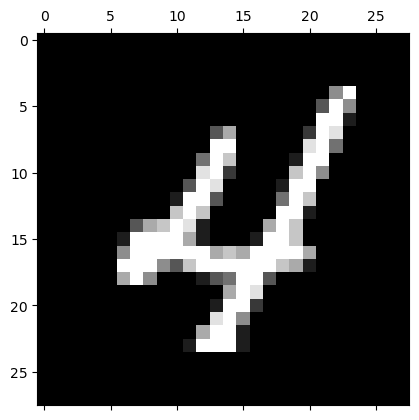

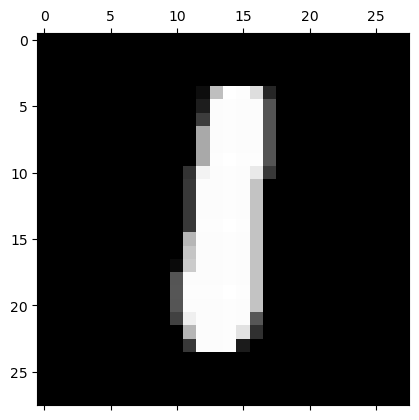

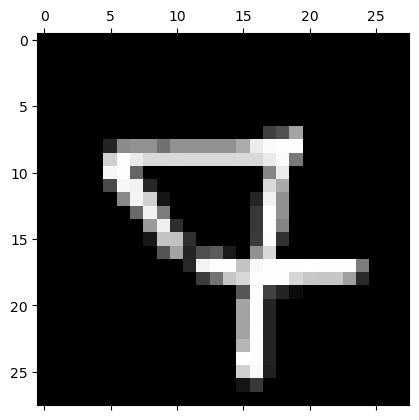

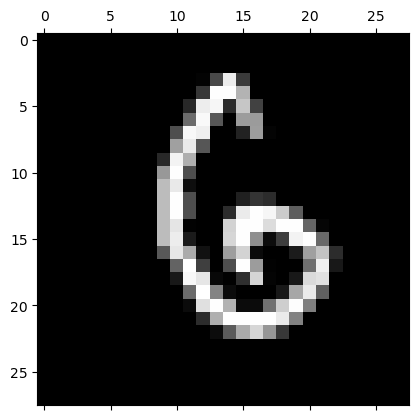

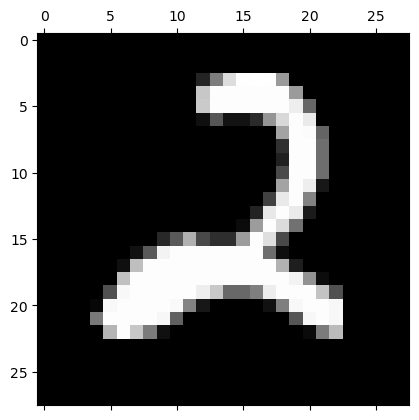

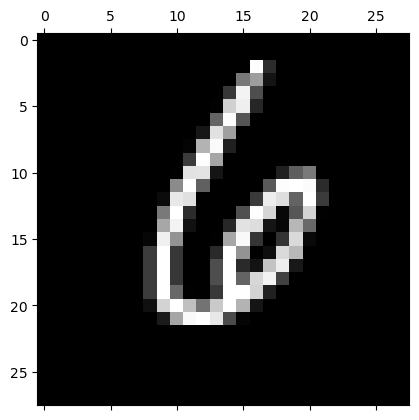

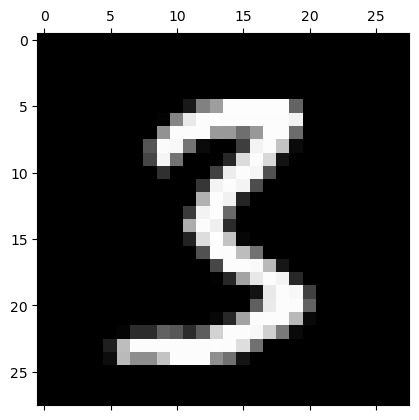

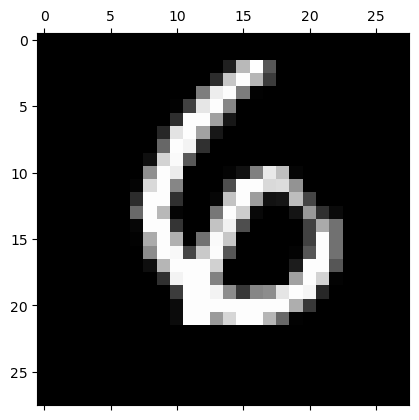

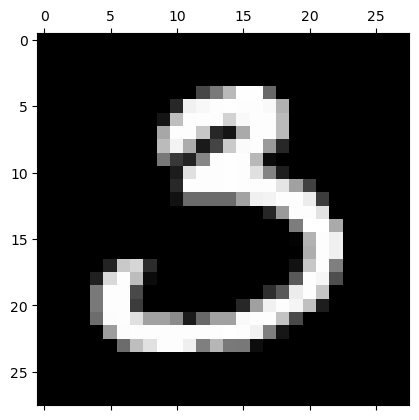

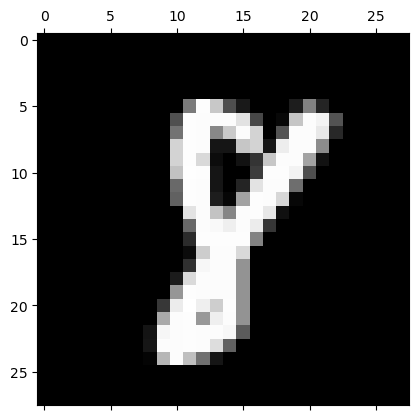

In [28]:
import matplotlib.pyplot as plt
for i,data in enumerate(train_loader):
    X,y = data
    for j in range(10):
        plt.matshow(X[j].reshape((28,28)), cmap = plt.get_cmap('gray'))
    plt.show()
    break

In [29]:
import torch.nn.functional as F
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,padding=2)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.activate = nn.Sigmoid()
        
    def forward(self,x):
#         print(x.shape)
        x = self.pool1(self.activate(self.conv1(x)))
        x = self.pool2(self.activate(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 16*5*5)
        x = self.activate(self.fc1(x))
        x = self.activate(self.fc2(x))
        x = self.fc3(x)
        return x



In [66]:
class LeNet5Plus(nn.Module):
    def __init__(self):
        super(LeNet5Plus,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,5,padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(84,10)
            
        
        )
    def forward(self,x):
        x = self.conv(x)
        x = self.linear(x)
        return x

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 单GPU或者CPU
print(device)
net = LeNet5Plus().to(device)
lr = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
def train_epoch(net,train_loader,optim,loss):
    net.train()
#     print(net.fc3.weight)
    losses = 0
    L = 0
    for data in train_loader:
        X,y = data
        X,y = X.to(device),y.to(device)
#         print(X.shape,y.shape)
        optim.zero_grad()
        y_pre = net(X)
#         print(y_pre.shape,y.shape)
        l = loss(y_pre,y)
        L+=X.shape[0]
        l.backward()
        losses+=l.item()
        optim.step()
    net.eval()
    return losses/L
def train(network,epochs,train_loader,val_loader):
    LOSS = []
    ACC_TRAIN = []
    ACC_VAL = []
    acc = 0
    best_model = None
    for epoch in range(epochs):
        epoch_loss = train_epoch(network,train_loader,optimizer,loss)
        acc_val = test(network,val_loader)
        acc_train = test(network,train_loader)
        LOSS.append(epoch_loss)
        ACC_TRAIN.append(acc_train)
        ACC_VAL.append(acc_val)
        if acc_val>acc:
            acc = acc_val
            best_model = network
#         print ('Epoch [{}/{}], Loss {:.4f}, acc: {}%'.format(epoch+1, epochs, epoch_loss,acc)) 
    plt.plot(range(epochs),LOSS,label='loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    plt.plot(range(epochs),ACC_TRAIN,label='train acc')
    plt.plot(range(epochs),ACC_VAL,label='val acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    return best_model
    
def test(net,test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            X,y = data
            X,y = X.to(device),y.to(device)
            y_pre = net(X)
            _, predicted = torch.max(y_pre.data, dim=1)
#             print(y_pre[0],predicted[0],y[0])
            total += y.size(0)
            correct += (predicted == y).sum().item() 
#     print('epoch %d: accuracy on test set: %d %% ' % (epoch,100 * correct / total))
    return 100 * correct / total
        

cuda:0


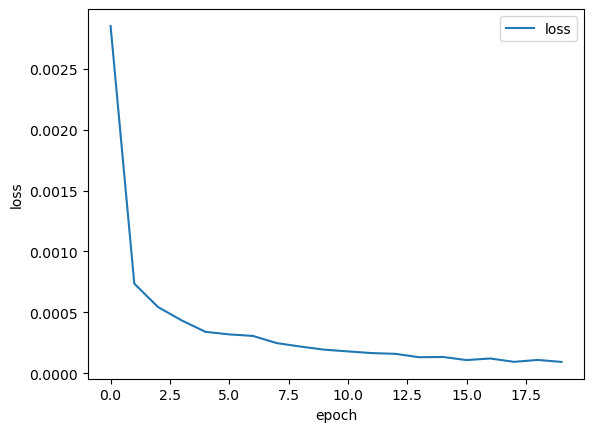

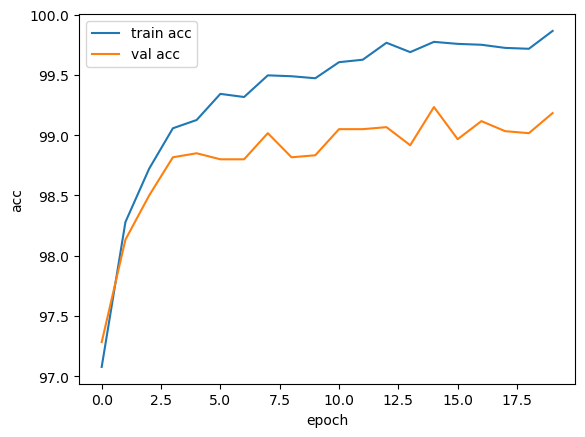

test acc: 99.21%:


In [68]:
model = train(net,20,train_loader,val_loader)
acc_test = test(model,test_loader)
print("test acc: {}%:".format(acc_test))